In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
from sqlalchemy import create_engine

In [3]:
engine = create_engine(   
"mssql+pyodbc:///?odbc_connect="
"Driver%3D%7BODBC+Driver+17+for+SQL+Server%7D%3B"
"Server%3Drliddb.int.lcog.org%2C5433%3B"
"Database%3DRLIDGeo%3B"
"Trusted_Connection%3Dyes%3B"
"ApplicationIntent%3DReadWrite%3B"
"WSID%3Dclwrk4087.int.lcog.org%3B")

In [4]:
import pyodbc
import pandas as pd

In [5]:
cnxn = pyodbc.connect("Driver={SQL Server};"
                      "Server=rliddb.int.lcog.org,5433;"
                      "Database=RLIDGeo;"
                      "Trusted_Connection=yes;")

In [6]:
df = pd.read_sql_query('select * from dbo.Road', cnxn)
df.head()

,OBJECTID,Shape,seg_id,lcpwid,eugid,sprid,lcogid,dir,name,type,...,method,contributor,ugbcity,one_way,fnode,tnode,f_zlev,t_zlev,optcost,road_segment_gfid
0,1,b'b\x0b\x00\x00\x01\x04\x18\x00\x00\x00@IOB\xd...,NaN,940700.0,NaN,NaN,NaN,,FRANKLIN SCHOOL,RD,...,TEMP,LCPW,None,None,20986,16194,5,5,15.296079,B9A25964-3E11-4720-8E4D-DD2D94C9E529
1,2,"b""b\x0b\x00\x00\x01\x14\xe0\xc6\xb8\x01^hPA\x0...",NaN,801200.0,NaN,NaN,NaN,,ALCORN,ST,...,GPS,LCPW,None,None,8806,9118,5,5,6.654660,4F2D2734-426C-44D3-BC2D-1A6DF887CEA2
2,3,b'b\x0b\x00\x00\x01\x04\t\x00\x00\x00\xa0\xa6\...,NaN,855700.0,NaN,NaN,NaN,,WALLING,ST,...,GPS,LCPW,None,None,25084,14338,5,5,19.050228,21A8682D-3EB3-4C2B-923F-B4A625CCD942
3,4,b'b\x0b\x00\x00\x01\x04\r\x00\x00\x00\xe0Ex\x0...,NaN,915900.0,NaN,NaN,NaN,,RAILROAD,LN,...,GPS,LCPW,None,None,18268,6720,5,5,23.706264,CCA03FF9-D8E6-48A4-A15E-83658DC7AA64
4,5,"b'b\x0b\x00\x00\x01\x14\xe0\xf1x,\xba\nQA\x00B...",NaN,NaN,NaN,NaN,NaN,,PETE NEWELL,DR,...,TRAV,LCPW,None,None,5355,8724,5,5,5.617668,CC0B8C91-7E90-4F94-AC7F-32A129E9C6C1


In [7]:
list(df)

['OBJECTID',
 'Shape',
 'seg_id',
 'lcpwid',
 'eugid',
 'sprid',
 'lcogid',
 'dir',
 'name',
 'type',
 'airsname',
 'rlidname',
 'l_ladd',
 'l_hadd',
 'r_ladd',
 'r_hadd',
 'mailcity',
 'county',
 'state',
 'zipcode',
 'fclass',
 'fed_class',
 'airsclass',
 'cclass',
 'paved',
 'speed',
 'snowroute',
 'owner',
 'maint',
 'source',
 'method',
 'contributor',
 'ugbcity',
 'one_way',
 'fnode',
 'tnode',
 'f_zlev',
 't_zlev',
 'optcost',
 'road_segment_gfid']

In [8]:
df.fed_class.unique()

array(['Local', 'Major Collector', 'Other Principal Arterial',
       'Collector', 'Other Freeways and Expressways', 'Minor Collector',
       'Minor Arterial', 'Interstate', None], dtype=object)

In [33]:
# Principal Arterials, Minor Arterials, and Major Collectors
selected = ['Major Collector', 'Other Principal Arterial', 'Minor Arterial']

In [41]:
sql = '''
SELECT 
OBJECTID AS id,
name,
type,
fed_class,
Shape.STAsBinary() AS geometry
FROM dbo.Road;
'''

In [42]:
roads = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geometry' )

In [43]:
roads.crs

In [44]:
roads.crs = "EPSG:2914"

In [45]:
roads = roads.to_crs(epsg=3857)

In [46]:
network = roads[roads['fed_class'].isin(selected)]

In [16]:
MPObd = gpd.read_file("V:/Data/Transportation/MPO_Bound.shp")

In [47]:
network = gpd.clip(network, MPObd)

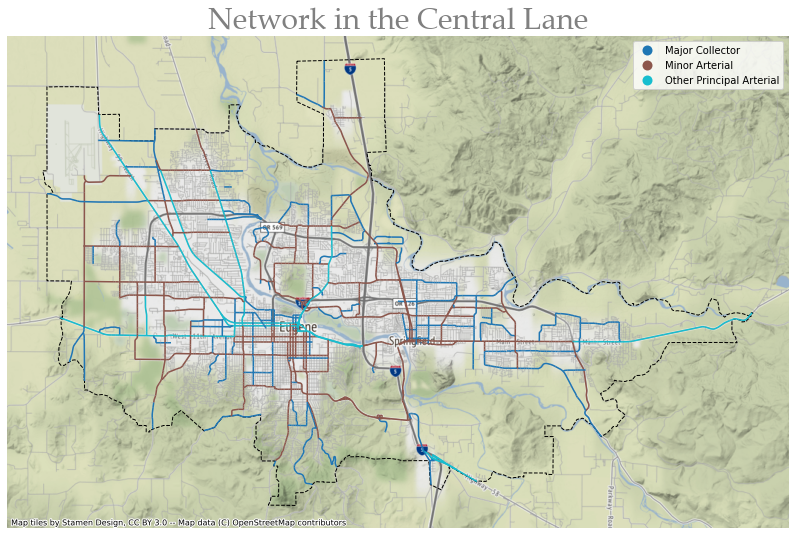

In [48]:
# compare with this map: https://www.lcog.org/DocumentCenter/View/47/Roadway-Functional-Classification-PDF?bidId=
fig, ax = plt.subplots(figsize=(14, 12))
network.plot(ax=ax, column='fed_class', cmap='tab10', legend=True, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', aspect=1)
ctx.add_basemap(ax)
plt.title("Network in the Central Lane", fontsize=30, fontname="Palatino Linotype", color="grey")
ax.axis("off")
plt.show()

In [37]:
outpath = r'T:\MPO\RTP\FY20 2045 Update\Data and Resources\PerformanceAnalysis'

In [49]:
network.head()

,id,name,type,fed_class,geometry
208,210,AYRES,RD,Major Collector,"LINESTRING (-13701910.120 5481217.713, -137019..."
213,215,AYRES,RD,Major Collector,"LINESTRING (-13701615.348 5481206.862, -137016..."
237,239,RIVER,AVE,Major Collector,"LINESTRING (-13705016.630 5480409.094, -137049..."
252,254,RIVER,AVE,Major Collector,"LINESTRING (-13704575.406 5480372.173, -137045..."
257,259,TERRY,ST,Major Collector,"LINESTRING (-13713458.691 5479775.646, -137134..."


In [50]:
network.to_file(os.path.join(outpath, "network.shp"))